# Reconstruction with Phase Fitting

Good resource on digital holographic microscopy: [Ulf Schnars and Werner P O Juptner, Meas. Sci. Technol. 13 (2002) R85–R101](http://x-ray.ucsd.edu/mediawiki/images/d/df/Digital_recording_numerical_reconstruction.pdf)

In [58]:
%matplotlib inline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def peakshift(arr, shifts):
    '''
    Take 2D array `arr` and roll the contents in 
    two dimensions, with shifts set by the elements
    of `shifts` for the (x,y) directions.
    
    Parameters
    ----------
    arr : `N x M` dim array
        Array to roll
    shifts : list of length `M`
        Desired shifts in x, y directions
    '''
    return np.roll(np.roll(arr, shifts[0], axis=0), 
                   shifts[1], axis=1)

def apodize(arr):
    '''
    Force the magnitude at the boundaries go to zero
    '''
    N = np.shape(arr)[0]
    y, x = np.mgrid[0:N, 0:N]
    xmask = np.cos((x-N/2.)*np.pi/N)**0.25
    ymask = np.cos((y-N/2.)*np.pi/N)**0.25
    return arr*xmask*ymask

def calc_mask(img, centerx=285, centery=200, radius=250):
    '''
    Calculate the Fourier-space mask to isolate the real image
    '''
    N = np.shape(img)[0]
    y, x = np.mgrid[0:N, 0:N]
    mask = np.zeros(np.shape(img))
    mask[(x-centerx)**2 + (y-centery)**2 < radius**2] = 1.0
    return mask

def calc_G(d, wavelength=405e-9, dx=3.45e-6, dy=3.45e-6):
    '''
    Calculate the Fourier transform of impulse response function,
    for reconstruction at distance `d`
    '''
    y, x = np.mgrid[0:N, 0:N] - N/2
    A = wavelength**2*(x+N**2*dx**2/(2.0*d*wavelength))**2/(N**2*dx**2)
    B = wavelength**2*(y+N**2*dy**2/(2.0*d*wavelength))**2/(N**2*dy**2)
    G = np.exp(-1j*2.0*np.pi*d/wavelength*np.sqrt(1.0-A-B))
    return G

def calc_R(Psi, wavelength=405e-9, dx=3.45e-6, dy=3.45e-6, plots=False):
    '''
    Calculate the reconstructed wave
    '''
    m = 100 #margin for phase fitting
    r = [900, 155]
    c = [147, 900]
    order = 3
    OPD = wavelength / (2*np.pi)
    y, x = np.mgrid[0:N, 0:N] - N/2
    pixvec = x[0, m:-m]
    img2 = np.fft.ifft2(Psi)
    img2 = peakshift(img2, [N/2, N/2])
    pimg2 = np.arctan(np.imag(img2)/np.real(img2)); 

    px = np.unwrap(pimg2[r, m:-m,]*2.0)/2*OPD
    py = np.unwrap(pimg2[m:-m, c].T*2.0)/2*OPD
    px = np.mean(px, axis=0)
    py = np.mean(py, axis=0)

    pxpoly = np.polyfit(pixvec, px, order)
    pypoly = np.polyfit(pixvec, py, order)

    R = np.exp(-1j/OPD*(np.polyval(pxpoly, x) + np.polyval(pypoly, y)))
    if plots:
        fig, ax = plt.subplots(1,figsize=(15,8))
        ax.plot(pixvec, px/(wavelength/(2*np.pi)))
        ax.plot(pixvec, np.polyval(pxpoly, pixvec)/OPD, 'r--')

        plt.figure()
        plt.imshow(np.arctan(np.imag(R)/np.real(R)))#, origin='lower')
        plt.title('Fitted phase mask')
        plt.show()
    return R

# Read input image
inputfile = '/Users/bmorris/SHAMU/emilio/Development/Hologram.tif'
img = np.array(Image.open(inputfile))

N = np.shape(img)[0]
mask = calc_mask(img)

# "apodize" the image
img = apodize(img)
# Isolate the real image in Fourier space
Fh = np.fft.fft2(img)*mask
absFh = np.abs(Fh)
# Find spectral peak
spectrum_centroid = np.unravel_index(absFh.T.argmax(), absFh.shape)#[::-1]

if False:
    fig, ax = plt.subplots(1,2,figsize=(14,8))
    ax[0].scatter(*spectrum_centroid, color='w')
    ax[0].imshow(np.log10(np.abs(Fh)), origin='lower')
    ax[0].set_title('Masked fourier space (log)')

    ax[1].imshow(img)
    ax[1].set_title('Apodized Image')
    plt.show()

In [59]:
# Center the spectral peak
Fh = peakshift(Fh, [N/2-spectrum_centroid[1], N/2-spectrum_centroid[0]])
# Calculate Fourier transform of impulse response function
G = calc_G(3.6/100)
# Apodize the result
Psi = apodize(Fh*G)
# Calculate Reconstructed wave
R = calc_R(Psi,plots=False)

# Reconstruct the image
Fh = np.fft.fft2(img*R)
Fh = Fh*mask
Fh = peakshift(Fh, [N/2 - spectrum_centroid[1], N/2 - spectrum_centroid[0]])
Psi = Fh*G
img2 = np.fft.ifft2(Psi);
img2 = peakshift(img2, [N/2, N/2]) #MATLAB index correction

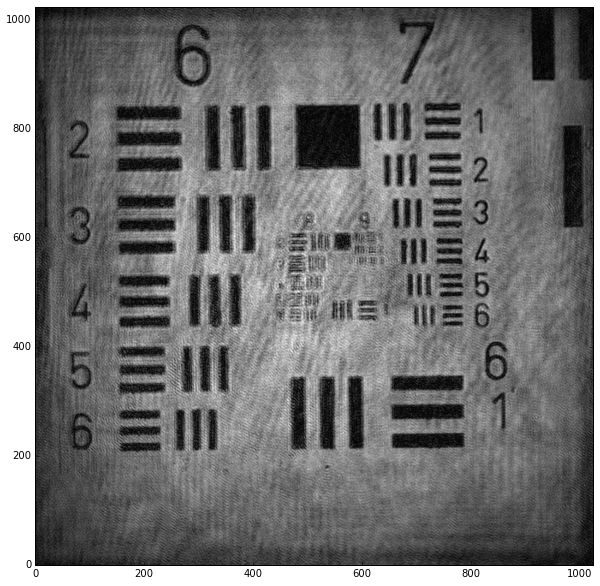

In [60]:
magimg2 = np.abs(img2)
pimg2 = np.arctan(np.imag(img2)/np.real(img2))
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(magimg2[::-1,::-1], cmap=plt.cm.binary_r, origin='lower')
plt.show()